In [1562]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from camera_utils import fix_barrel_distortion
import math

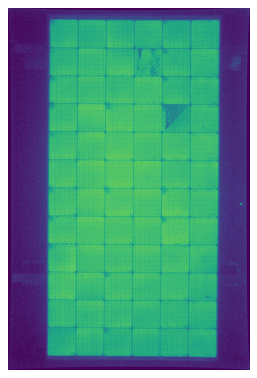

In [1563]:
# image = cv2.imread("C:/Users/chuck/OneDrive/Desktop/Honors/EL_images/Q72712M1801AJO0421_IMG_8916.JPG", )
# image = cv2.imread("C:/Users/chuck/OneDrive/Desktop/Honors/BT1/BT1/F52J01525101_IMG_8993.JPG")
image = cv2.imread("C:/Users/chuck/OneDrive/Desktop/Honors/EL_images/Q72712M1802ARK1119_IMG_8918.JPG")
toml_path = "C:/Users/chuck/OneDrive/Desktop/Honors/solarEL/solarel/configs/camera_config.toml"
image = fix_barrel_distortion(image, toml_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.fastNlMeansDenoising(image, None, )
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(image)

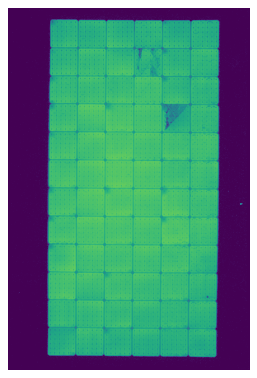

In [1564]:
image_cp = np.copy(image)
image_cp = cv2.blur(image_cp, (5,5))
temp = np.ravel(image_cp)
avg_intensity = int(np.mean(temp))
_, thresh = cv2.threshold(image, avg_intensity - 0.3*np.std(temp), 255, cv2.THRESH_TOZERO)
# th3 = cv2.adaptiveThreshold(thresh,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,11,2)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(thresh)

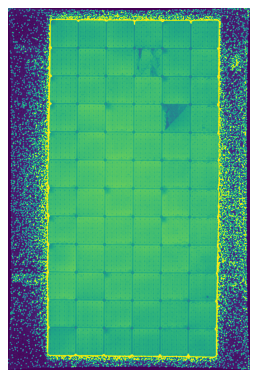

In [1565]:
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
image_cp = cv2.drawContours(image_cp, contours, -1, (255,255,255), 10)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(image_cp)

[[ 416   97]
 [ 416 4171]
 [2534 4171]
 [2534   97]]


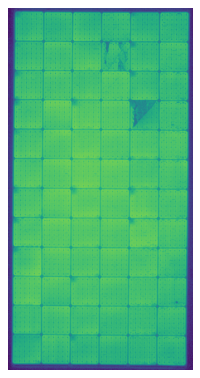

In [1566]:
def largest_rectangle(contours):
    # Approximate contours to polygons and find the largest rectangle
    largest_rect = None
    max_area = 0
    for cnt in contours:
        # Approximate the contour to a polygon
        poly = cv2.approxPolyDP(cnt, 0.03*cv2.arcLength(cnt,True), True)
        # If the polygon has 4 vertices (is a rectangle)
        if len(poly) == 4:
            # Calculate the area of the polygon
            area = cv2.contourArea(poly)
            # If the area is larger than the current maximum
            if area > max_area:
                # Update the maximum area and largest rectangle
                max_area = area
                largest_rect = poly
    # Return the largest rectangle
    return largest_rect

rect = largest_rectangle(contours)
# Convert the list of points to a numpy array
rect = np.array(rect)
x, y, w, h = cv2.boundingRect(rect)
height, width = np.shape(image_cp)[:2]
delta = 50
rect = np.array([[max(x-delta, 0), max(y-delta, 0)], [max(x-delta, 0), min(y+h+delta, height)],\
                  [min(x+w+delta, width), min(y+h+delta, height)], [min(x+w+delta, width), max(y-delta, 0)]])
print(rect)
# Reshape the array to a 1D array of (x, y) tuples
points = rect.reshape(-1, 2)
src_pts = np.float32(points)

dest_pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]])

M = cv2.getPerspectiveTransform(src_pts, dest_pts)
image_cp = np.copy(image)
# Apply the perspective transform to the image
cropped = cv2.warpPerspective(image_cp, M, (w, h))
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cropped)

(3974, 2018)
(994, 505)


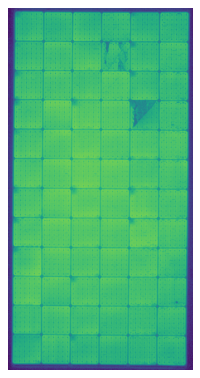

In [1567]:
cropped_cp = np.copy(cropped)
print(np.shape(cropped_cp))
cropped_cp = cv2.pyrDown(cropped_cp)
cropped_cp = cv2.pyrDown(cropped_cp)
print(np.shape(cropped_cp))
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cropped)

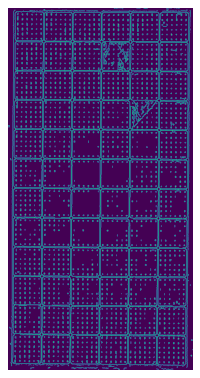

In [1568]:
edges = cv2.Canny(cropped_cp, 60, 110)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(edges)

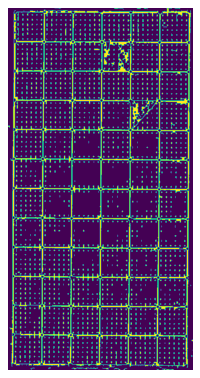

In [1569]:
kernel = np.ones((4, 4), np.uint8)
edges = cv2.dilate(edges, kernel)
kernel = np.ones((4, 4), np.uint8)
edges = cv2.erode(edges, kernel) 
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(edges)

In [1570]:
def horz_hough_lines(edges, votes, pixels):
    lines = None
    while lines is None:
        lines = cv2.HoughLines(edges, pixels, np.pi/180, votes)
        votes = int(votes*0.95)
        
    good_lines = []
    # Loop over the detected lines
    for line in lines:
        _, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        slope = - a / b if b != 0 else 100 # divide by zero saftey
        # Check if the line is approximately horizontal
        if abs(slope)<0.2:
            good_lines.append(line)
    return good_lines

def vert_hough_lines(edges, votes, pixels):
    lines = None
    while lines is None:
        lines = cv2.HoughLines(edges, pixels, np.pi/180, votes)
        votes = int(votes*0.95)

    good_lines = []
    # Loop over the detected lines
    for line in lines:
        _, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        slope = - a / b if b != 0 else 100 # divide by zero saftey
        # Check if the line is approximately horizontal
        if abs(slope)>50:
            good_lines.append(line)
    return good_lines

def draw_hough_lines(image, hough_lines):
    # Loop over the detected lines
    for line in hough_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)
    return image

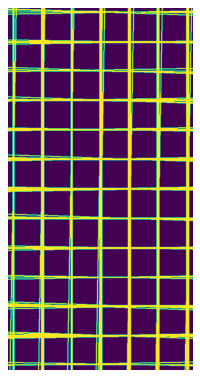

In [1571]:
horz_lines = horz_hough_lines(edges, 300, 1.5)
vert_lines = vert_hough_lines(edges, 600, 1.5)
lines = horz_lines + vert_lines

edges_cp = np.copy(edges) * 0
cells = draw_hough_lines(edges_cp, lines)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cells)

In [1572]:
def merge_similar_hough_lines(lines):
    """
    Merges similar Hough lines in OpenCV.
    
    :param lines: list of lines in (rho, theta) format.
    :param threshold_distance: maximum distance between lines to be considered similar.
    :param threshold_angle: maximum angle difference between lines to be considered similar.
    :return: list of merged lines in (rho, theta) format.
    """
    rho_threshold = 30
    theta_threshold = 0.2

     # how many lines are similar to a given one
    similar_lines = {i : [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue

            rho_i,theta_i = lines[i][0]
            rho_j,theta_j = lines[j][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                similar_lines[i].append(j)

    # ordering the INDECES of the lines by how many are similar to them
    indices = [i for i in range(len(lines))]
    indices.sort(key=lambda x : len(similar_lines[x]))

    # line flags is the base for the filtering
    line_flags = len(lines)*[True]
    for i in range(len(lines) - 1):
        if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
            continue

        for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
            if not line_flags[indices[j]]: # and only if we have not disregarded them already
                continue

            rho_i,theta_i = lines[indices[i]][0]
            rho_j,theta_j = lines[indices[j]][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

    filtered_lines = []

    if filter:
        for i in range(len(lines)): # filtering
            if line_flags[i]:
                filtered_lines.append(lines[i])

    return filtered_lines

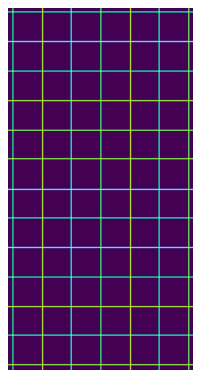

In [1573]:
lines = merge_similar_hough_lines(lines)
edges_cp = np.copy(edges) * 0
cells = draw_hough_lines(edges_cp, lines)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cells)

(994, 505)
(3976, 2020)


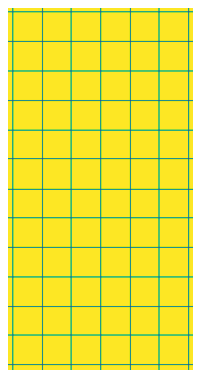

In [1574]:
print(np.shape(cells))
cells = cv2.pyrUp(cells)
cells = cv2.pyrUp(cells)
print(np.shape(cells))
kernel = np.ones((4, 4), np.uint8)
cells = cv2.erode(cells, kernel)
cells = cv2.bitwise_not(cells)
_, cells = cv2.threshold(cells, 50, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cells)

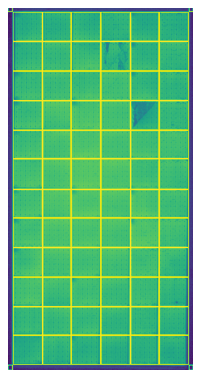

In [1575]:
def find_similar_contours(example_shape, contours):
    similar_contours = []

    for contour in contours:
        # Approximate the contour with a polygon
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        similarity = cv2.matchShapes(approx, example_shape, cv2.CONTOURS_MATCH_I1, 0)
        if similarity < 0.05:
            similar_contours.append(contour)
            
    return similar_contours

contours, hierarchy = cv2.findContours(cells, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
panel_shape = np.array([[0,0], [0,1], [1,1], [1,0]])
panel_contours = find_similar_contours(panel_shape, contours)
cropped_cp = np.copy(cropped)
cropped = cv2.drawContours(cropped, panel_contours, -1, (255,255,255), 10)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cropped)

In [1576]:
panel_images = []

def width_and_height_filter(contours, width, height, tolerance):
    good_contours = []
    for contour in panel_contours:
        _, _, w, h = cv2.boundingRect(contour)
        if w < width*(1-tolerance) or w > width * (1+tolerance):
            continue
        if h < height*(1-tolerance) or w > height * (1+tolerance):
            continue
        good_contours.append(contour)
    return good_contours

panel_contours = width_and_height_filter(panel_contours, 325, 325, 0.2)

In [1577]:
def sort_contours(contours):
    centers = []
    for contour in contours:
        M = cv2.moments(contour)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        centers.append((cx, cy))
    
    # Sort the contours by their x-coordinate
    sorted_indices = np.argsort([center[1] for center in centers])
    sorted_contours = [contours[i] for i in sorted_indices]

     # Split the contours into rows
    rows = []
    row_indices = []
    prev_center_y = None
    for i, contour in enumerate(sorted_contours):
        center_x, center_y = centers[sorted_indices[i]]
        if prev_center_y is None or center_y - prev_center_y > 10:
            row_indices.append([i])
            rows.append([contour])
        else:
            row_indices[-1].append(i)
            rows[-1].append(contour)
        prev_center_y = center_y
    
    # Sort the contours within each row by their x-coordinate
    for i, row in enumerate(rows):
        row_sorted_indices = np.argsort([centers[sorted_indices[j]][0] for j in row_indices[i]])
        rows[i] = [row[j] for j in row_sorted_indices]

    return rows

rows = sort_contours(panel_contours)

In [1578]:
def label_image(image, text,font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=2, color=(255, 255, 255), thickness=2):
    # Get the dimensions of the image
    height, width = image.shape
    
    # Get the dimensions of the text
    text_width, text_height = cv2.getTextSize(text, font, font_scale, thickness)[0]
    
    # Compute the position of the text
    text_x = int((width - text_width) / 2)
    text_y = int((height + text_height) / 2)
    
    # Put the text on the image
    cv2.putText(image, text, (text_x, text_y), font, font_scale, (0,0,0), thickness+1)
    cv2.putText(image, text, (text_x, text_y), font, font_scale, color, thickness)

56 56 318 318
380 56 306 318
692 56 318 318
1016 56 318 318
1340 56 306 318
1652 56 318 318
56 380 318 318
380 380 306 318
692 380 318 318
1016 380 318 318
1340 380 306 318
1652 380 318 318
56 704 318 318
380 704 306 318
692 704 318 318
1016 704 318 318
1340 704 306 318
1652 704 318 318
56 1028 318 318
380 1028 306 318
692 1028 318 318
1016 1028 318 318
1340 1028 306 318
1652 1028 318 318
56 1352 318 306
380 1352 306 306
692 1352 318 306
1016 1352 318 306
1340 1352 306 306
1652 1352 318 306
56 1664 318 330
380 1664 306 330
692 1664 318 330
1016 1664 318 330
1340 1664 306 330
1652 1664 318 330
56 2000 318 306
380 2000 306 306
692 2000 318 306
1016 2000 318 306
1340 2000 306 306
1652 2000 318 306
56 2312 318 318
380 2312 306 318
692 2312 318 318
1016 2312 318 318
1340 2312 306 318
1652 2312 318 318
56 2636 318 318
380 2636 306 318
692 2636 318 318
1016 2636 318 318
1340 2636 306 318
1652 2636 318 318
56 2960 318 318
380 2960 306 318
692 2960 318 318
1016 2960 318 318
1340 2960 306 318
16

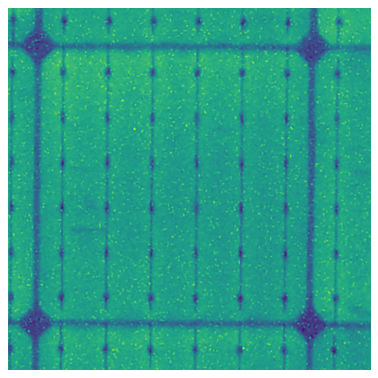

In [1579]:
i = 0
height, width = np.shape(cropped_cp)
panel_image_rows = []
for row in rows:
    panel_image_rows.append([])
    for contour in row:
        x,y,w,h = cv2.boundingRect(contour)
        print(x,y,w,h)
        delta = 50
        panel_image = cropped_cp[max(0, y-delta):min(y+h+delta, height), max(0, x-delta):min(x+w+delta, width)]
        # label_image(panel_image, f'{i}')
        panel_images.append(panel_image)
        panel_image_rows[-1].append(panel_image)
        i += 1

example = panel_images[57]
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(example)

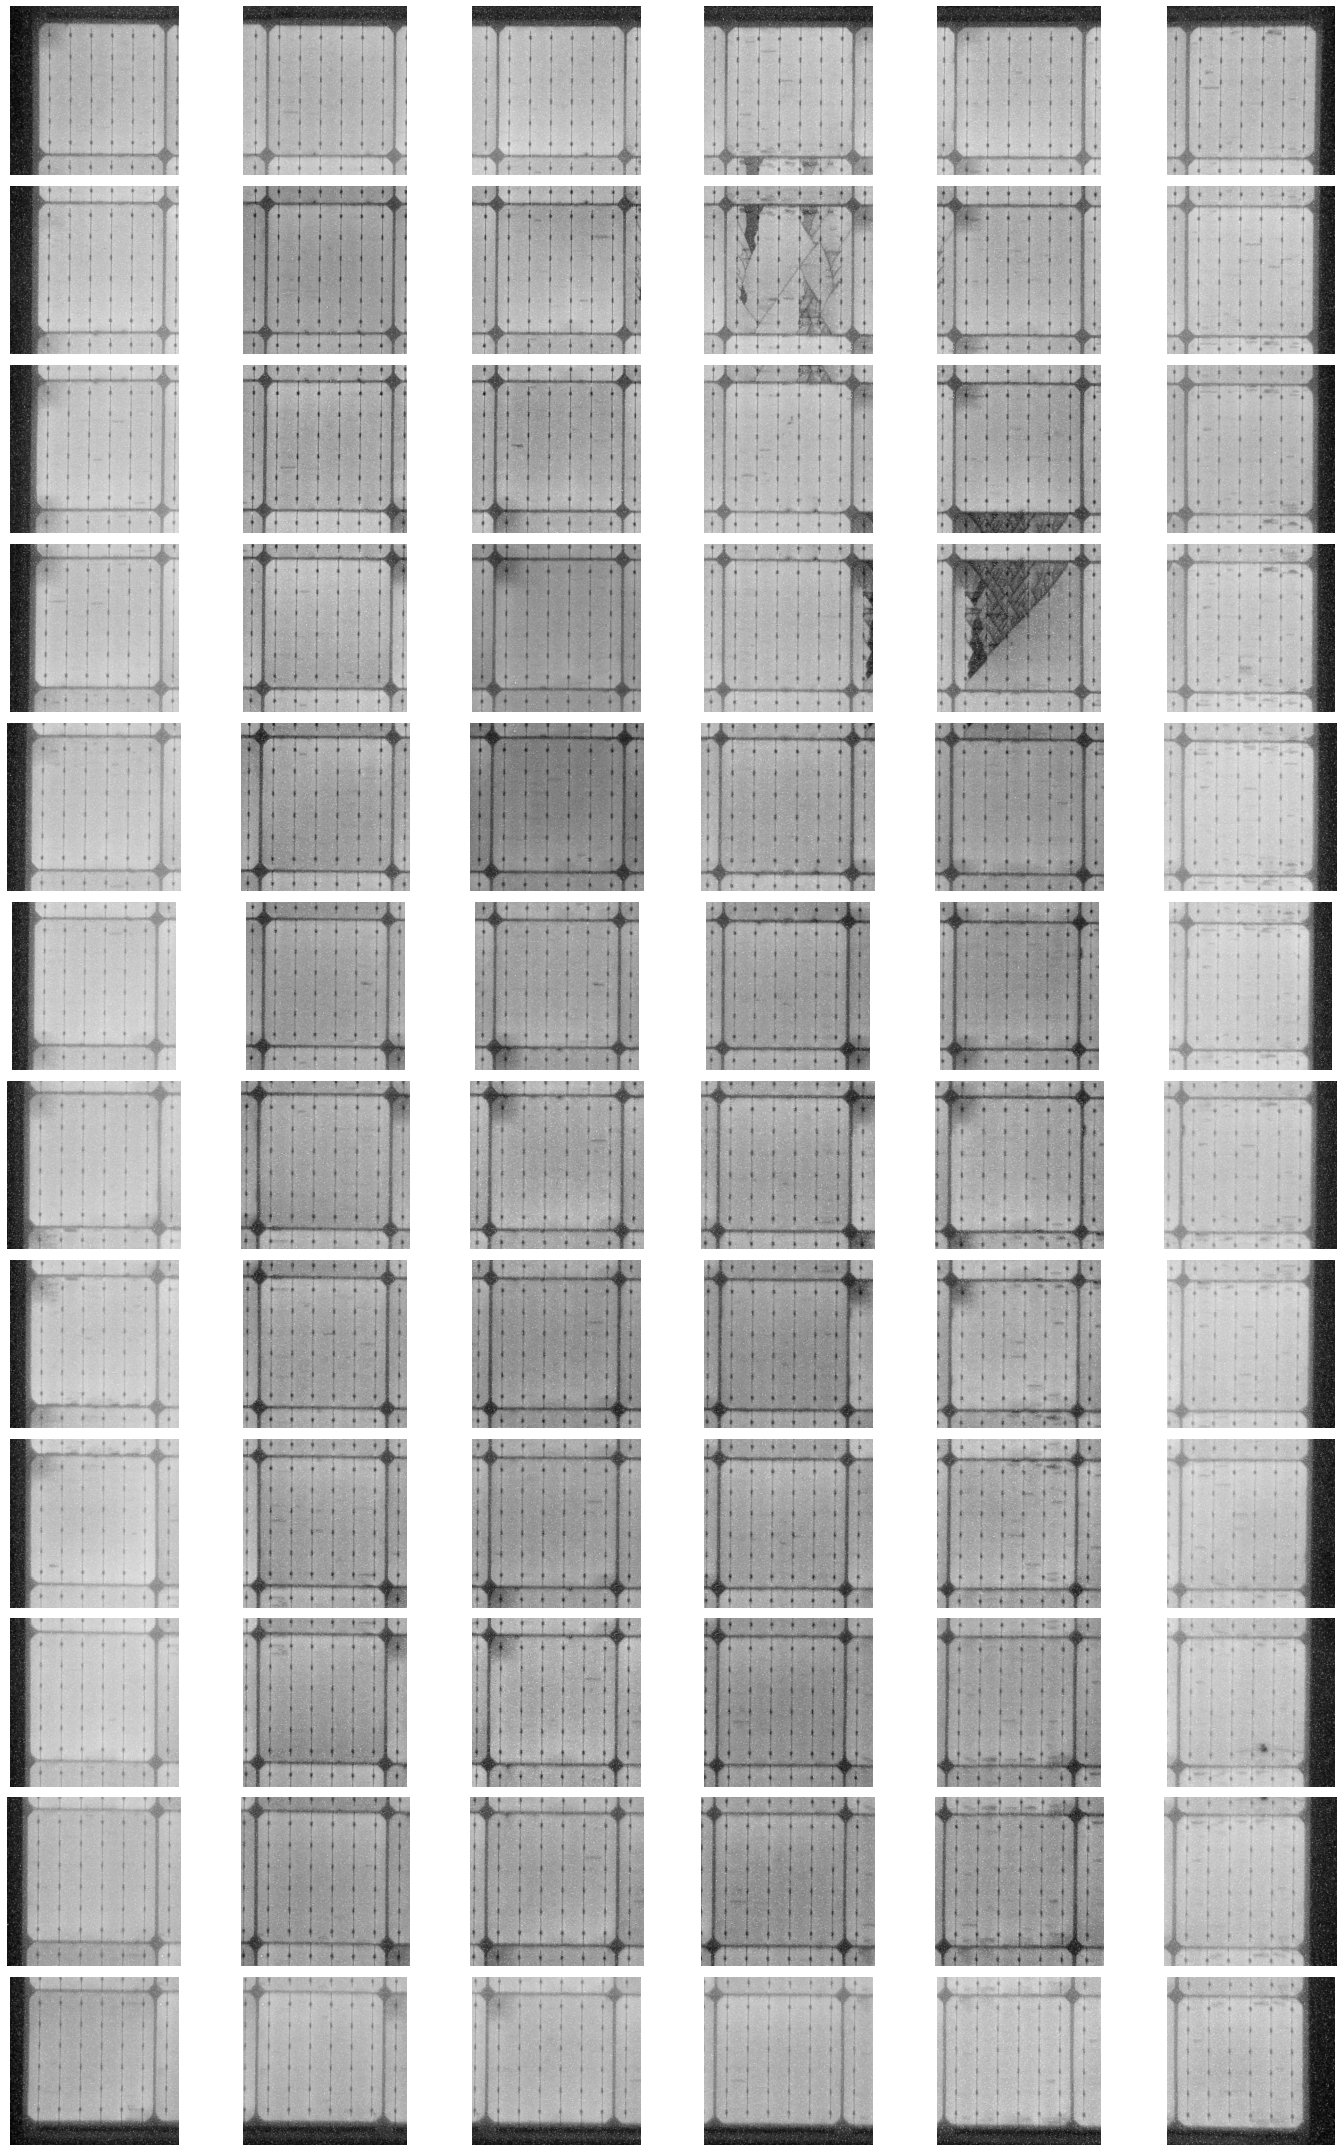

In [1580]:

num_rows, num_cols = np.shape(panel_image_rows)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 30))

for row in range(num_rows):
    for col in range(num_cols):
        # Generate a random image for each subplot
        image = panel_image_rows[row][col]

        # Display the image in the current subplot
        axs[row, col].imshow(image, cmap='gray')
        axs[row, col].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()
# Show the plot
plt.show()

# Cell Clean up

(418, 416)


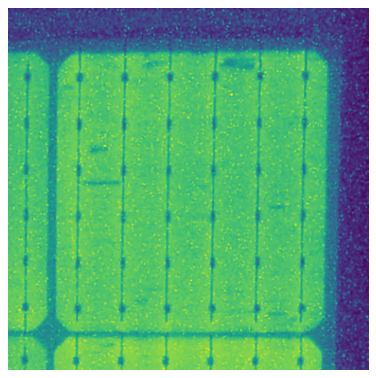

In [1581]:
example = panel_images[5]
print(np.shape(example))
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(example)

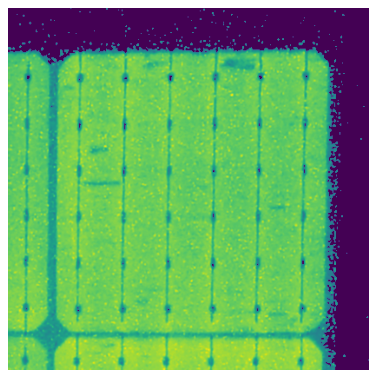

In [1582]:
example_1 = np.copy(example)
example_1 = cv2.blur(example_1, (2,2))
temp = np.ravel(example_1)
avg_intensity = int(np.mean(temp))
th = int(avg_intensity - np.std(temp))
max_val = 255
ret, threshold = cv2.threshold(example_1, th, max_val, cv2.THRESH_TOZERO)
# threshold2 = cv2.adaptiveThreshold(example,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,5)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(threshold)

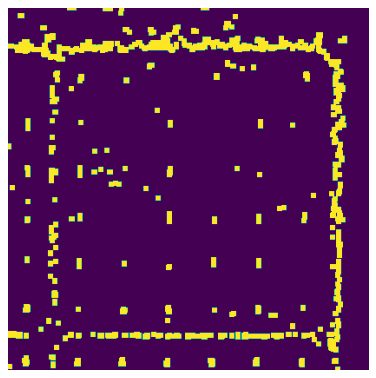

In [1587]:
th3 = cv2.adaptiveThreshold(threshold,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
kernel = np.ones((4, 4), np.uint8)
th3 = cv2.dilate(th3, kernel)
kernel = np.ones((6, 6), np.uint8)
th3 = cv2.erode(th3, kernel) 
th3 = cv2.bitwise_not(th3)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(th3)

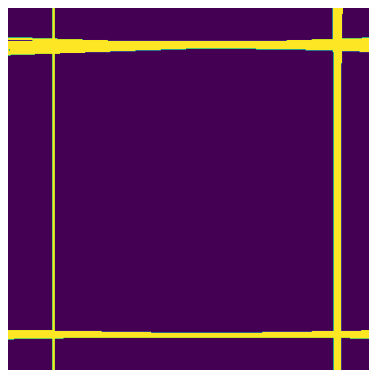

In [1589]:
horz_lines = horz_hough_lines(th3, 320, 1.5)
vert_lines = vert_hough_lines(th3, 320, 1.5)
lines = horz_lines + vert_lines

th3_cp = np.copy(th3) * 0
th3_cp = draw_hough_lines(th3_cp, lines)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(th3_cp)

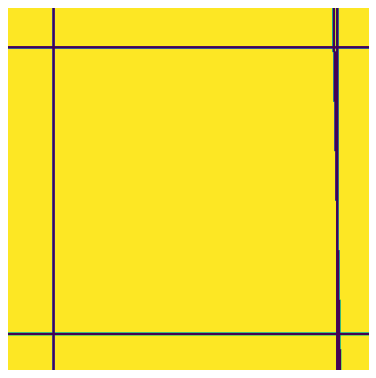

In [1590]:
lines = merge_similar_hough_lines(lines)
th3_cp = np.copy(th3_cp) * 0
cell = draw_hough_lines(th3_cp, lines)
cell = cv2.bitwise_not(cell)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cell)

In [1591]:
def find_largest_contour(thresholded_img):
    contours, hierarchy = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    return approx

print(find_largest_contour(cell))

[[[ 54  48]]

 [[ 54 374]]

 [[377 374]]

 [[373  48]]]
